In [1]:
import numpy as np
from math import pi
from scipy import signal
from matplotlib import pyplot as plt

# References:
# [1] P.P. Vaidyanathan, ROBUST DIGITAL FILTER STRUCTURES, in HANDBOOK FOR DIGITAL SIGNAL PROCESSING. S.K. Mitra and J.F. Kaiser Eds. Wiley-Interscience, N.Y., 1993, Chapter 7.
# [2] P.P. Vaidyanathan, MULTIRATE SYSTEMS AND FILTER BANKS, Prentice Hall, N.Y., Englewood Cliffs, NJ, 1993, Chapter 3.

In [2]:
def numrecursion(r, N, c):
    q = np.zeros(N + 1, dtype=complex)

    # Initialize recursion
    q[0] = np.sqrt(-r[0] / c, dtype=complex)
    q[N] = np.conj(c * q[0], dtype=complex)
    q[1] = -r[1] / (2 * c * q[0])
    q[N - 1] = np.conj(c * q[1], dtype=complex)

    # The limit of the for loop depends on the order being odd or even
    for n in range(3, int(np.ceil(N / 2)) + 1):
        q[n - 1] = (-r[n - 1] / c - np.dot(q[1:n - 1], q[n - 2:0:-1])) / (2 * q[0])
        q[N + 1 - n - 1] = np.conj(c * q[n - 1])

    # Compute middle coefficient separately when order is even
    if N % 2 == 0:
        q[int((N + 2) / 2) - 1] = (-r[int((N + 2) / 2) - 1] / c - np.dot(q[1:int((N + 2) / 2) - 1],
                                                                         q[int((N + 2) / 2) - 2:0:-1])) / (2 * q[0])
    return q


def powercompnum(b, r, N, c=1):
    """
    Compute numerator of power complementary filter.
    """
    # Check if b is real and c has default value
    if np.isreal(b).all() and c == 1:
        # Try to get a real q with c = 1 and c = -1
        q = numrecursion(r, N, 1)

        if not np.isreal(q).all():
            q = numrecursion(r, N, -1)

        if not np.isreal(q).all():
            print('A real power complementary filter could not be found')
            return q
    else:
        if np.size(c) > 1:
            print('C must be a complex scalar.')
            return None
        if abs(c) - 1 > np.power(np.finfo(float).eps, 2/3):
            print('C must be of magnitude one.')
            return None

        q = numrecursion(r, N, c)

    return q

def auxpoly(b, a):
    revb = np.conj(b[::-1])
    reva = np.conj(a[::-1])

    r = np.subtract(np.convolve(revb, b), np.convolve(a, reva))

    return r

def iirpowcomp(b, a):
    # Find the auxiliary polynomial R(z)
    r = auxpoly(b, a)

    # Compute the numerator of the power complementary transfer function
    q = powercompnum(b, r, len(b) - 1)
    return q, a

def sortnums(b, bp):
    # Sort numerators prior to calling ALLPASSDECOMPOSITION.
    # ALLPASSDECOMPOSITION always requires the first argument to
    # be symmetric. The second argument can be symmetric or antisymmetric.

    # If b is real and antisymmetric, make it the second argument
    if np.max(np.abs(np.add(b, b[::-1]))) < np.finfo(float).eps ** (2 / 3):
        p = bp
        q = b
    else:
        p = b
        q = bp

    return p, q

def allpassdecomposition(p, q, a):
    # If q is real and antisymmetric, make it imaginary
    if np.all(np.isreal(q)):
        if np.max(np.abs(np.add(q, q[::-1]))) < np.finfo(float).eps ** (2 / 3):
            q = q * 1j

    z = np.roots(p - 1j * q)

    # Initialize the allpass functions
    d1 = np.array([1.0])
    d2 = np.array([1.0])

    # Separate the zeros inside the unit circle and the ones outside to form the allpass functions
    for n in range(len(z)):
        if np.abs(z[n]) < 1:
            d2 = np.convolve(d2, [1, -z[n]])
        else:
            d1 = np.convolve(d1, [1, -1 / np.conj(z[n])])

    # Remove roundoff imaginary parts
#     d1 = imagprune(d1)
#     d2 = imagprune(d2)

    beta = np.sum(d2) * (np.sum(p) + 1j * np.sum(q)) / np.sum(a) / np.sum(np.conj(d2))

    return d1, d2, beta

def imagprune(poly):
    # Function to remove roundoff imaginary parts
    real_part = np.real(poly)
    imag_part = np.imag(poly)
    imag_part[np.abs(imag_part) < np.finfo(float).eps] = 0
    pruned_poly = real_part + imag_part * 1j
    return pruned_poly

In [3]:
def tf2ca(b, a):
    bp, a = iirpowcomp(b, a)
    p, q = sortnums(b, bp)
    d1, d2, beta = allpassdecomposition(p,q,a)
    return d1, d2, beta

In [4]:
def LinkwitzRiley12dB(fc, sr):
    omega = 2 * pi * fc / sr
    
    sineOmega = np.sin(omega)
    cosineOmega = np.cos(omega)
    A0 = 1 + sineOmega + cosineOmega
    
    A1 = (sineOmega - cosineOmega - 1)
    B0 = (sineOmega)
    B1 = (sineOmega)
    
    b_lp = np.convolve([B0, B1], [B0, B1])
    a_lp = np.convolve([1, A1], [1, A1])
    
    A1 = (sineOmega - cosineOmega - 1)
    B0 = (1 + cosineOmega)
    B1 = -(1 + cosineOmega)
    
    b_hp = np.convolve([B0, B1], [B0, B1])
    a_hp = np.convolve([A0, A1], [A0, A1])
    
    # two transfer function need to substract to achieve all-pass filter  
    return [-b_lp, a_lp], [b_hp, a_hp]

def LinkwitzRiley24dB(fc, sr):
    omega = 2 * pi * fc / sr
    
    sineOmega = np.sin(omega)
    cosinePmega = np.cos(omega)
    alpha = sineOmega * np.sqrt(2) / 2
    A0 = 1 + alpha
    
    A1 = -( 2 * cosinePmega)
    A2 = (1 - alpha) 
    B1 = (1 - cosinePmega) 
    B0 = B1 / 2
    B2 = B0
    
    b_lp = np.convolve([B0, B1, B2], [B0, B1, B2])
    a_lp = np.convolve([A0, A1, A2], [A0, A1, A2])
    
    A1 = -(2 * cosinePmega) 
    A2 = (1 - alpha) 
    B1 = -(1 + cosinePmega) 
    B0 = -B1 / 2
    B2 = B0
    
    b_hp = np.convolve([B0, B1, B2], [B0, B1, B2])
    a_hp = np.convolve([A0, A1, A2], [A0, A1, A2])
    
    return [b_lp, a_lp], [b_hp, a_hp]

In [5]:
LP, HP = LinkwitzRiley12dB(60, 48000)
d1, d2, beta = tf2ca(LP[0], LP[1])

print(d1, d2, beta)

[ 1.        +0.00000000e+00j -0.50197898-4.68768145e-05j] [ 1.        +0.00000000e+00j -0.50197898+4.68768145e-05j] (-6.242006965383347e-05-1.0000000377113913j)


In [6]:
LP, HP = LinkwitzRiley24dB(1200, 48000)
d1, d2, beta = tf2ca(LP[0], LP[1])

print(d1, d2, beta)

[ 1.        +0.j         -1.76325972-0.04650996j  0.78765907+0.03706894j] [ 1.        +0.j         -1.76325972+0.04650996j  0.78765907-0.03706894j] (0.06653273528487683+1.41256618950328j)


In [7]:
b = np.array([-6.00862921190370605e-08, -1.80258876357111182e-07, -1.80258876357111182e-07, -6.00862921190370605e-08])
a = np.array([1.0, -2.98429207710246303, 2.96870728140036411, -0.984414723607564435])
d1, d2, beta = tf2ca(b, a)

print(d1, d2, beta)

[ 1.       +0.00000000e+00j -0.9921767-4.26473933e-13j] [ 1.        +0.00000000e+00j -1.99211538+4.34098070e-13j
  0.99217682-4.27423721e-13j] (-1.0000000006369814-2.1725183960632963e-10j)


In [11]:
# b, a = signal.cheby1(3, 0.5, 0.4)
# d1, d2, beta = tf2ca(b,a)

num = 0.5 * np.convolve(d1[::-1].real, d2.real) + 0.5 * np.convolve(d2[::-1].real, d1.real)
den = np.convolve(d1.real, d2.real)

print(num, b)
print(den, a)

[6.00862904e-08 1.80258878e-07 1.80258878e-07 6.00862904e-08] [-6.00862921e-08 -1.80258876e-07 -1.80258876e-07 -6.00862921e-08]
[ 1.         -2.98429208  2.96870728 -0.98441472] [ 1.         -2.98429208  2.96870728 -0.98441472]


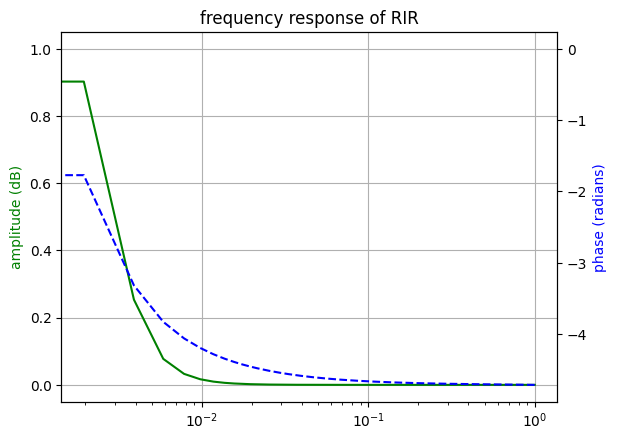

In [9]:
w, h = signal.freqz(num, den)

amplitude = abs(h)
angle = np.unwrap(np.angle(h))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

plt.title('frequency response of RIR')
plt.xlabel(r'normalized frequency (x$\pi$rad/sample)')

ax1.plot(w/max(w), amplitude, 'g')
ax1.set_ylabel('amplitude (dB)', color='g')
# ax1.set_ylim(-120, 6)
ax1.grid()

ax2.plot(w/max(w), angle, 'b--')
ax2.set_ylabel('phase (radians)', color='b')

plt.xscale("log")
plt.show()